**классификатор текстов LSTM + W2V**

Евгений Борисов <borisov.e@solarl.ru>

Национальный корпус русского языка  
https://ruscorpora.ru/new/


Russian Distributional Thesaurus  
https://nlpub.ru/Russian_Distributional_Thesaurus    



Ю. В. Рубцова. Построение корпуса текстов для настройки тонового классификатора // Программные продукты и системы, 2015, №1(109)
http://study.mokoron.com


## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
import gc
# import gzip
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [10]:
# !wget -c https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
# !wget -c https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

In [11]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [12]:
neg = pd.read_csv('negative.csv',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [13]:
pos = pd.read_csv('positive.csv',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [14]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [15]:
data.sample(10)

,id,ttext,ttype
42397,414078301964369920,"Очень жалко, что они только 2 раза в неделю:(",-1
54507,415711491883827201,RT @xenia_sobchak: Я в аэропорту. И реально задыхаюсь.бедные красноярцы:(... Как вы живете с такими экологическими проблемами? Вы же травит…,-1
13747,410845242976632832,"Как же всё таки плохо,что мы не поехали в зимний лагерь : ((",-1
103642,411113594898898944,"Если Том приедет в Рашку,то я покрашусь в зеленый цвет,обещаю блин! Ахаха)",1
6552,409086806991179776,RT @naranzun: Шинэ жилээр ёолкон дээр хүүхнүүд аймаар адилхан болдог шүү...танигдах тэмдэг тавиарай даа..андуурсан тохиолдол байгаа шоо..:),1
92470,422089337967108096,@phosphormustdie он не пишет почти ничего(((,-1
87420,421235536422895616,"@m_athanasios @VRSoloviev вот елки палки :( думал о пиндосах поговорим, Синегале. Тут по ОРТ отца Афанасия показали.",-1
90159,410842209274302465,"А теперь смирись.Сейчас стало все ясно,с кем не бывает?И у тебя такое было!И все равно спасибо тебе,было круто;)",1
32016,409745183467507712,"@kaleriya_meow Панда,это кто?:D \nДай угадаю,хомяк?о.о",1
89627,410837813450375168,когда шли спокойной ночи малыши мама подпевала песенке из заставки:D\nмам ты норм?,1


## очистка данных

In [16]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'^@.*',' twit ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

In [17]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [18]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

  0%|          | 0/226833 [00:00<?, ?it/s]

In [19]:
data.sample(3)

,id,ttext,ttype,ttext_clean
54017,415574286884409344,"почему я такая бездарность?? ничего не получается (( если я что-то начну делать, либо рисовать или украшать ёлку, всё равно хуйня получится",-1,"[почему, я, такая, бездарность, ничего, не, получается, sadsmile, если, я, что, то, начну, делать, либо, рисовать, или, украшать, ёлку, всё, равно, хуйня, получится]"
4003,409052810748387328,Офигенные:* Как этих ребят можно не любить? http://t.co/8Z8SlWhaA8,1,"[офигенные, kisssmile, как, этих, ребят, можно, не, любить, url]"
84526,420463613586202624,Как за иАло!!Скачивать аськи!!не навижу цифру 1((((,-1,"[как, за, иало, скачивать, аськи, не, навижу, цифру, digit, sadsmile]"


In [20]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

  0%|          | 0/226833 [00:00<?, ?it/s]

In [21]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [22]:
data.sample(3)

,id,ttext,ttype,ttext_clean
86378,410804125857640448,"@Alenka_Rusher да уже ничего, просто мне лилена мама звонила в тот момент, и Лилю искала)",1,"[twit, уже, ничего, просто, мне, лилена, мама, звонила, тот, момент, лилю, искала]"
8306,409106899519688705,RT @seweheniwy: Интересно живое выступление человекоподобных роботов играющих на настоящих инструментах это хуже или лучше фанеры? :),1,"[twit, интересно, живое, выступление, человекоподобных, роботов, играющих, настоящих, инструментах, это, хуже, или, лучше, фанеры, happysmile]"
186246,417930591485825024,Еду в Киев ((( Ужасно нехочу.блин как по мне это будет самый ужастный новый год. \nPs:спасите меня,-1,"[еду, киев, sadsmile, ужасно, нехочу, блин, как, мне, это, будет, самый, ужастный, новый, год, спасите, меня]"


## строим датасет

### кодируем word2vec

In [63]:
import gensim
gensim.__version__

'4.1.2'

In [ ]:
# %%time

# загружаем предобученный Gensim W2V

# https://nlpub.ru/Russian_Distributional_Thesaurus
    
# from gensim.models import KeyedVectors 
# w2v_file = 'tenth.norm-sz500-w7-cb0-it5-min5.w2v'
# w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True, unicode_errors='ignore')
# w2v.init_sims(replace=True)

In [25]:
%%time

# строим W2V на основе текстов

from multiprocessing  import cpu_count
from gensim.models.word2vec import Word2Vec

w2v_size = 128

w2v = Word2Vec(
    sentences=data['ttext_clean'].values, 
    vector_size=w2v_size, 
    window=4, 
    min_count=1, 
    workers=cpu_count(),
)

# w2v = Word2Vec( data['ttext_clean'].values, min_count=1, size=w2v_size, window=4, workers=4)
# with open('result/Word2Vec.pkl', 'wb') as f: pickle.dump(w2v, f)

CPU times: user 23.2 s, sys: 714 ms, total: 23.9 s
Wall time: 9.45 s


In [34]:
w2v_vocab = sorted([w for w in w2v.wv.index_to_key])
ppr(w2v_vocab)

записей: 181 101


In [36]:
ii = np.random.permutation(len(w2v_vocab))[:30]
for i in ii:
    w = w2v_vocab[i]
    ww = [ v[0] for v in w2v.wv.most_similar(w, topn=5) ]
    print( w,':',ww )

рекламируйте : ['момент', 'петух', 'слезливый', 'отрыла', 'болван']
фармакологию : ['дорогу', 'плитку', 'коллекцию', 'качалке', 'слюной']
помоют : ['назидаться', 'шатулину', 'фаулер', 'webcamtoy', 'историца']
пошловатые : ['грубые', 'поступки', 'которыми', 'плохие', 'здоровы']
смекалка : ['приветище', 'полин', 'awww', 'огого', 'projects']
пескорассыпателей : ['bakers', 'шланга', 'итальянском', 'соли', 'поднятая']
соревы : ['поедем', 'бассейн', 'соревнования', 'санках', 'пойдём']
белоруссию : ['праздничных', 'карибы', 'командную', 'паранормальные', 'неотложку']
знае : ['виками', 'лежите', 'нееееттт', 'dно', 'ралинк']
переходе : ['впрочем', 'пишется', 'хдд', 'неё', 'диман']
шоколадный : ['дэвид', 'тре', 'корпус', 'bang', 'такий']
допоет : ['роисся', 'выдлоипфдылва', 'образуют', 'срываешься', 'раздумьях']
ispu : ['поторопитесь', 'оценивает', 'помелло', 'красавчік', 'enigmbox']
национальная : ['общежитие', 'слоупок', 'елочка', 'аахахах', 'пидар']
плащ : ['динамо', 'він', 'feat', 'болып', '

In [37]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ w2v.wv.get_vector(w) for w in t ] )

  0%|          | 0/226831 [00:00<?, ?it/s]

In [38]:
%xdel w2v
%xdel w2v_vocab

In [39]:
code_max_len = data['code'].str.len().max()
code_max_len

32

In [40]:
data['code'].str.len().describe().astype(int)

count    226831
mean         10
std           3
min           1
25%           7
50%           9
75%          13
max          32
Name: code, dtype: int64

In [41]:
# дополняем последовательности до единого размера
z = [[0.]*w2v_size]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

  0%|          | 0/226831 [00:00<?, ?it/s]

In [42]:
data['code'].str.len().describe().astype(int)

count    226831
mean         32
std           0
min          32
25%          32
50%          32
75%          32
max          32
Name: code, dtype: int64

In [43]:
data['code'] = data['code'].progress_apply(np.array)

  0%|          | 0/226831 [00:00<?, ?it/s]

In [44]:
x = np.stack( data['code'].values )
x.shape

(226831, 32, 128)

In [45]:
x = np.flip(x,axis=1) # переворачиваем последовательности

In [46]:
n_classes=2
target = data['ttype'].values
target = (target+1)//2
y = np.eye(n_classes)[target]

y.shape

(226831, 2)

In [47]:
%xdel data

In [48]:
gc.collect()

154

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32, 128), (136098, 2), (90733, 32, 128), (90733, 2))

In [50]:
y_train.sum(axis=0),y_test.sum(axis=0),

(array([67097., 69001.]), array([44825., 45908.]))

In [51]:
%xdel x
%xdel y

In [52]:
gc.collect()

32

## строим нейросеть 

In [53]:
seq_len = x_train.shape[1]
x_train.shape , y_train.shape, seq_len, w2v_size

((136098, 32, 128), (136098, 2), 32, 128)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [55]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, w2v_size)))  
model.add(Dense(n_classes, activation='softmax'))

2022-02-21 15:54:27.144368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 15:54:27.887546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 15:54:27.888148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 15:54:27.904653: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [64]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

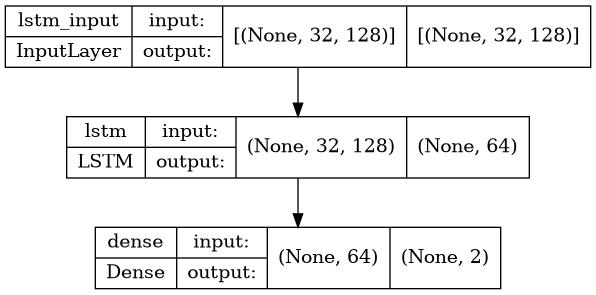

In [65]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True )

In [66]:
%%time

hist = model.fit(x_train,y_train, batch_size=1024, epochs=15, validation_split=.3)

2022-02-21 15:57:16.397814: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1560870912 exceeds 10% of free system memory.
2022-02-21 15:57:17.307577: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1560870912 exceeds 10% of free system memory.


Epoch 1/15


2022-02-21 15:57:27.580779: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


94/94 [==============================] - 14s 24ms/step - loss: 0.3590 - accuracy: 0.8133 - val_loss: 0.2456 - val_accuracy: 0.8666
Epoch 2/15
94/94 [==============================] - 2s 16ms/step - loss: 0.2390 - accuracy: 0.8698 - val_loss: 0.2407 - val_accuracy: 0.8648
Epoch 3/15
94/94 [==============================] - 2s 16ms/step - loss: 0.2300 - accuracy: 0.8741 - val_loss: 0.2569 - val_accuracy: 0.8552
Epoch 4/15
94/94 [==============================] - 2s 16ms/step - loss: 0.2288 - accuracy: 0.8739 - val_loss: 0.2388 - val_accuracy: 0.8630
Epoch 5/15
94/94 [==============================] - 2s 16ms/step - loss: 0.2216 - accuracy: 0.8786 - val_loss: 0.2262 - val_accuracy: 0.8733
Epoch 6/15
94/94 [==============================] - 2s 16ms/step - loss: 0.2176 - accuracy: 0.8818 - val_loss: 0.2223 - val_accuracy: 0.8774
Epoch 7/15
94/94 [==============================] - 1s 16ms/step - loss: 0.2153 - accuracy: 0.8835 - val_loss: 0.2210 - val_accuracy: 0.8783
Epoch 8/15
94/94 [=====

In [67]:
model.evaluate(x_test ,y_test )

2022-02-21 15:58:01.061483: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1486569472 exceeds 10% of free system memory.
2022-02-21 15:58:01.885491: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1486569472 exceeds 10% of free system memory.


2836/2836 [==============================] - 6s 2ms/step - loss: 0.2237 - accuracy: 0.8783


[0.22367466986179352, 0.8783243298530579]

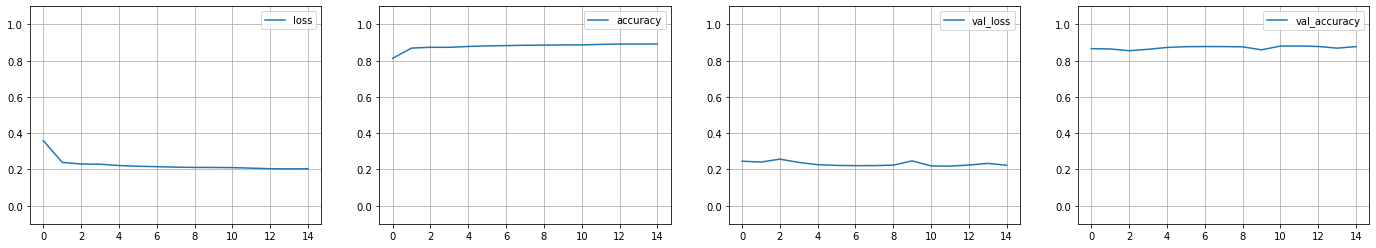

In [68]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])